About the Dataset:
https://archive.ics.uci.edu/ml/datasets/Computer+Hardware 

Directly from their Description:
1. Title: Relative CPU Performance Data 
2. Source Information
   -- Creators: Phillip Ein-Dor and Jacob Feldmesser
     -- Ein-Dor: Faculty of Management; Tel Aviv University; Ramat-Aviv; 
        Tel Aviv, 69978; Israel
   -- Donor: David W. Aha (aha@ics.uci.edu) (714) 856-8779   
   -- Date: October, 1987
3. Attribute Information:
   1. vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
   2. Model Name: many unique symbols
   3. MYCT: machine cycle time in nanoseconds (integer)
   4. MMIN: minimum main memory (RAM) in kilobytes (integer)
   5. MMAX: maximum main memory in kilobytes (integer)
   6. CACH: cache memory in kilobytes (integer)
   7. CHMIN: minimum channels in units (integer)
   8. CHMAX: maximum channels in units (integer)
   9. PRP: published relative performance (integer)
   10. ERP: estimated relative performance from the original article (integer), estimated by the authors using a linear regression.
4. Class Distribution: the class value (PRP) is continuously valued.
   PRP Value Range:   Number of Instances in Range:
   0-20               31
   21-100             121
   101-200            27
   201-300            13
   301-400            7
   401-500            4
   501-600            2
   above 600          4

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [2]:
df=pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data', sep=',',header=None, names=['vendor','model','machine_cycle_time','min_main_memory','max_main_memory','cache_memory','min_channels','max_channels','publ_rel_performance','est_rel_performance'])


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   vendor                209 non-null    object
 1   model                 209 non-null    object
 2   machine_cycle_time    209 non-null    int64 
 3   min_main_memory       209 non-null    int64 
 4   max_main_memory       209 non-null    int64 
 5   cache_memory          209 non-null    int64 
 6   min_channels          209 non-null    int64 
 7   max_channels          209 non-null    int64 
 8   publ_rel_performance  209 non-null    int64 
 9   est_rel_performance   209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


In [4]:
# I will drop 'model' since they are all distinct:
print(df['model'].nunique())
df=df.drop(['model'], axis=1)


209


array([[<AxesSubplot:title={'center':'machine_cycle_time'}>,
        <AxesSubplot:title={'center':'min_main_memory'}>,
        <AxesSubplot:title={'center':'max_main_memory'}>],
       [<AxesSubplot:title={'center':'cache_memory'}>,
        <AxesSubplot:title={'center':'min_channels'}>,
        <AxesSubplot:title={'center':'max_channels'}>],
       [<AxesSubplot:title={'center':'publ_rel_performance'}>,
        <AxesSubplot:title={'center':'est_rel_performance'}>,
        <AxesSubplot:>]], dtype=object)

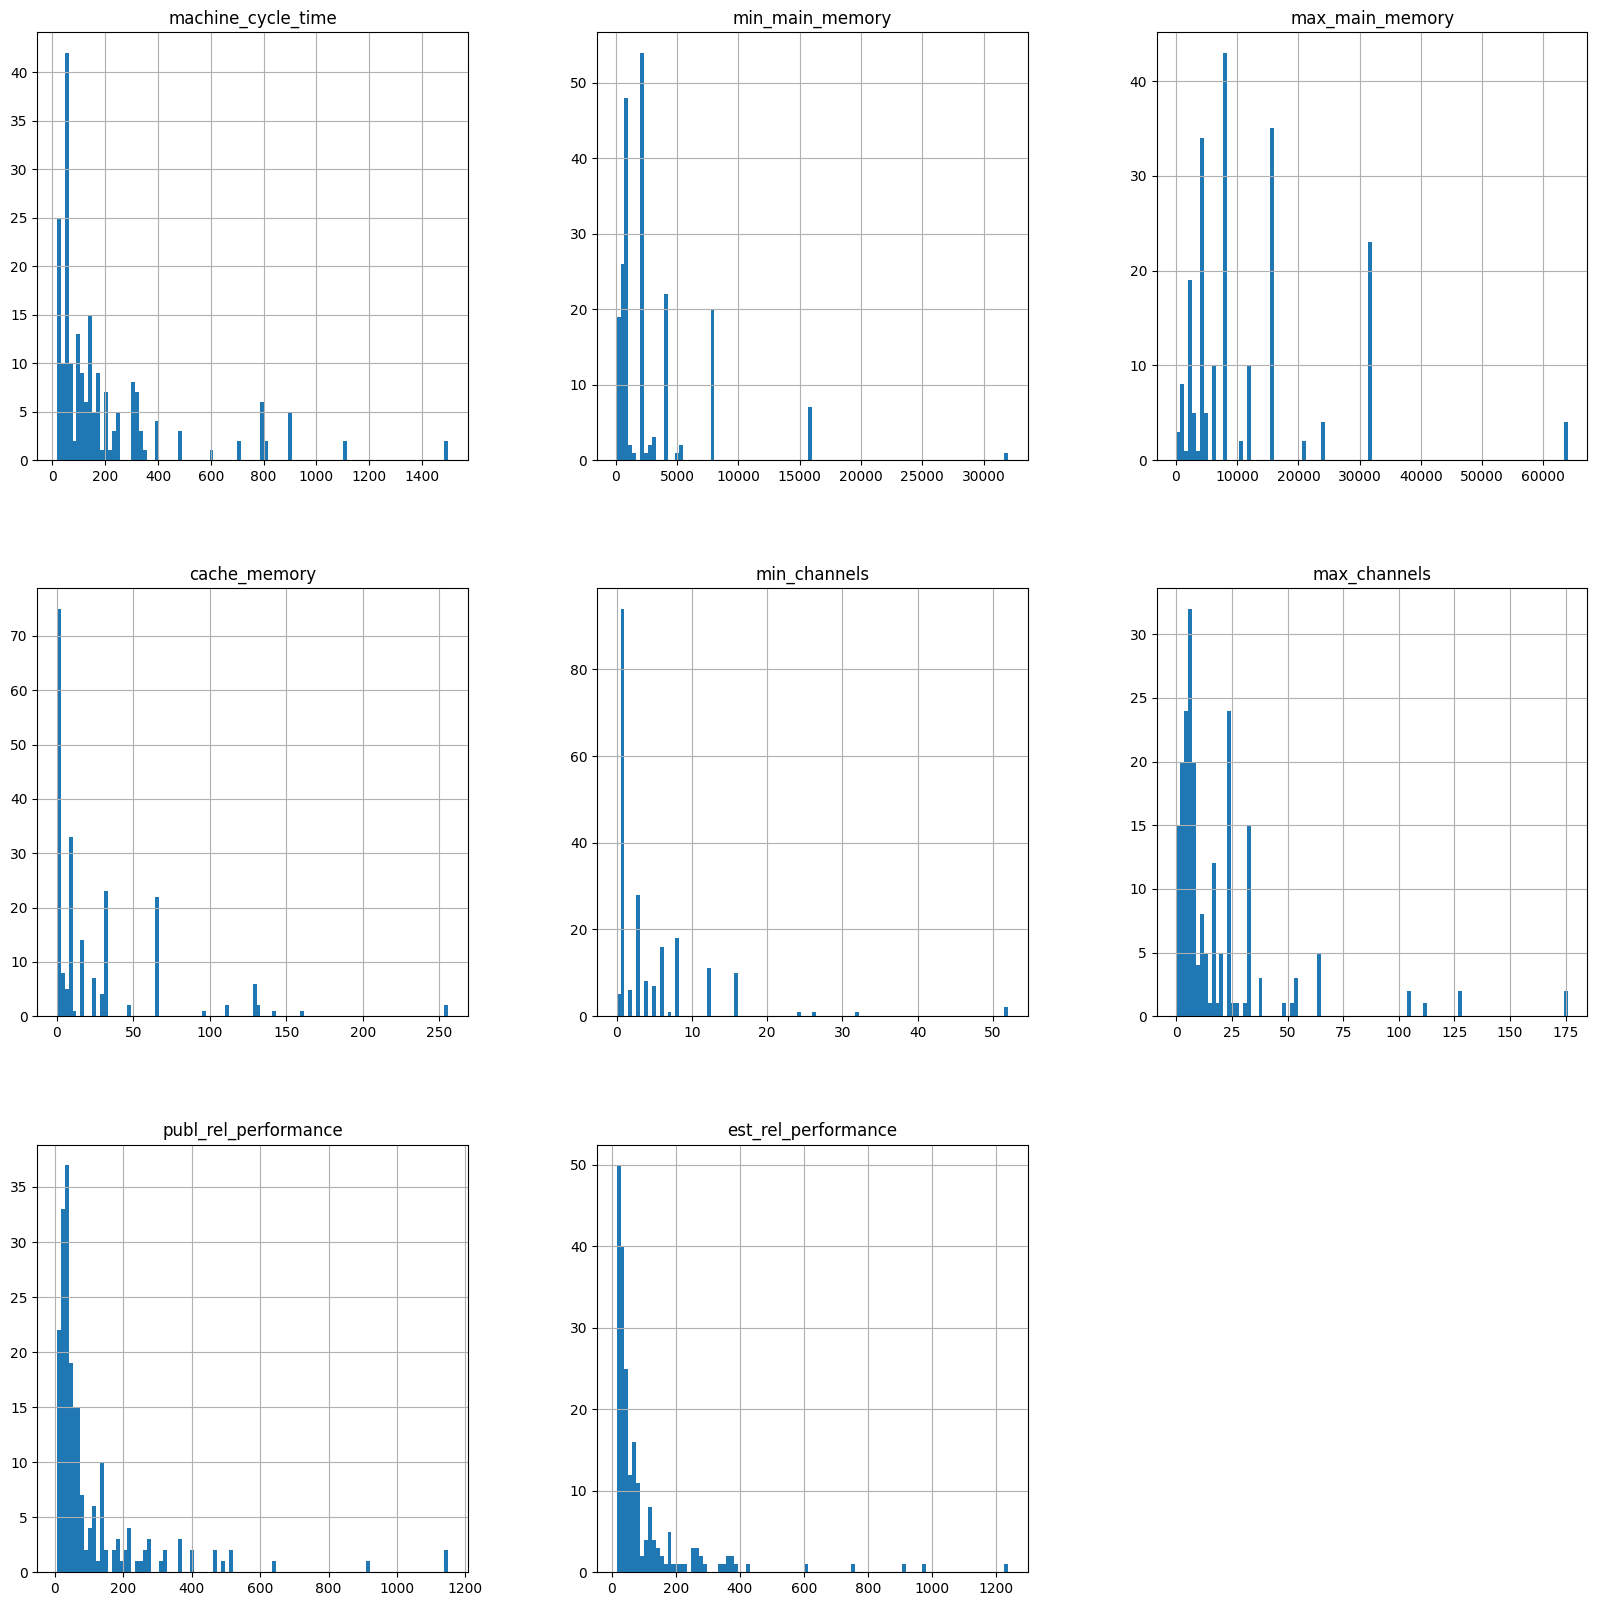

In [5]:
# All variables are skewed:
df.hist(bins=100,figsize=[20,20])


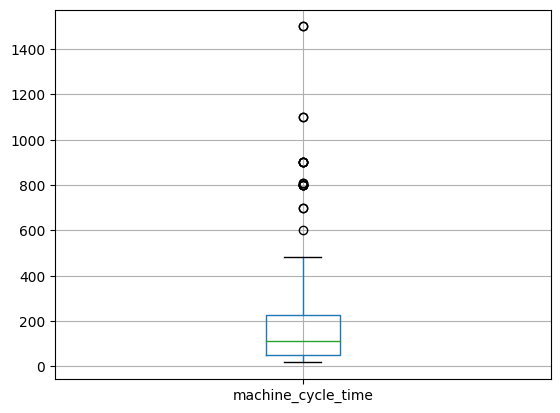

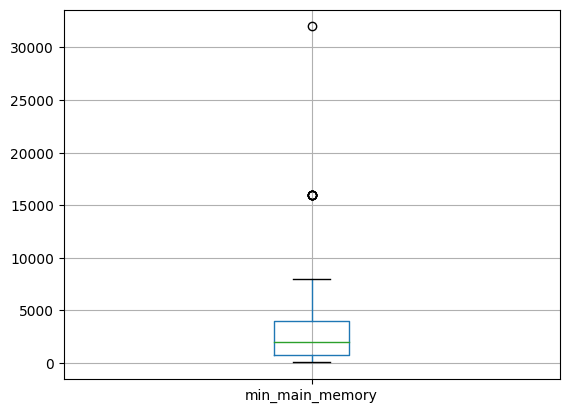

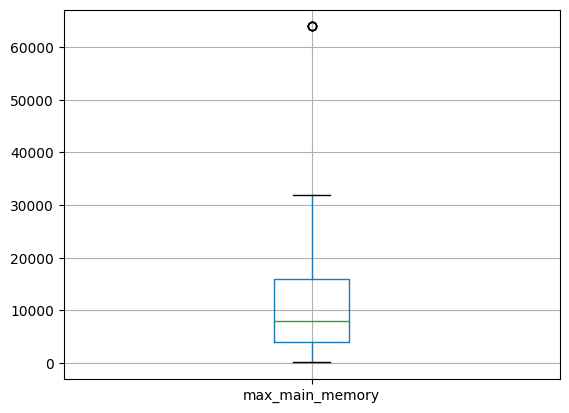

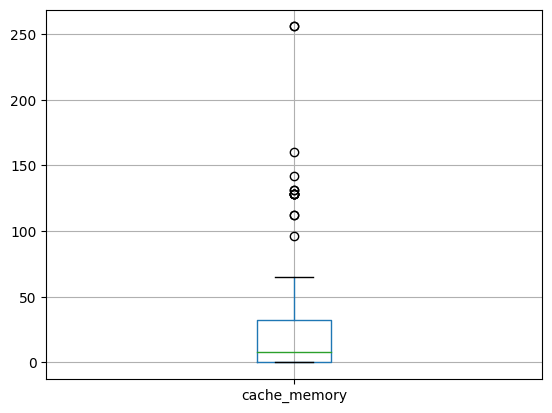

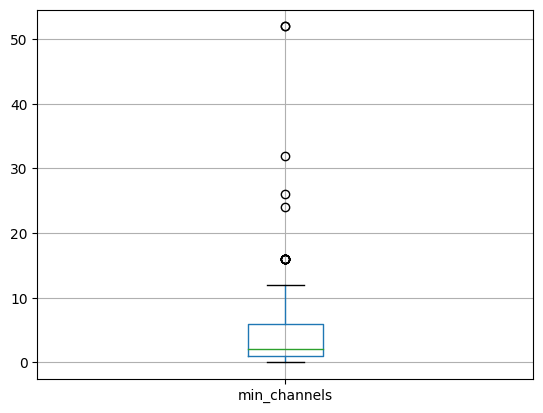

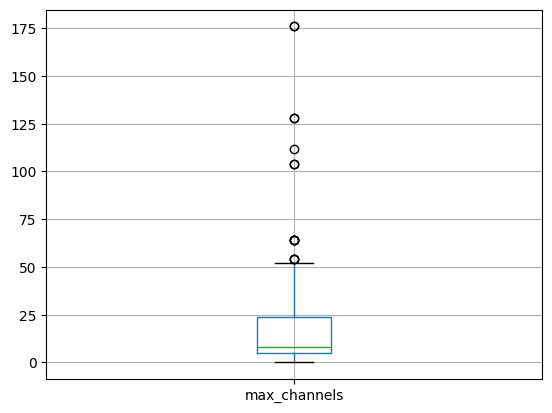

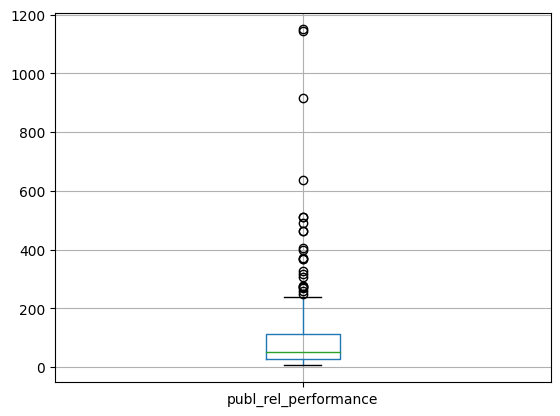

In [6]:
# Since the data is small, instead of dropping the outliers, I will consider robust scaling (with Huber Regression) to deal with the skewness.
num_col=['machine_cycle_time','min_main_memory','max_main_memory','cache_memory','min_channels','max_channels','publ_rel_performance']
for i in num_col:
    plt.figure()
    df[num_col].boxplot([i])
    

In [7]:
X=df.drop(['est_rel_performance'],axis=1)
y=df['est_rel_performance']

In [8]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=.25,random_state=12)

In [9]:
vendor_list=['adviser', 'amdahl', 'apollo', 'basf', 'bti', 'burroughs', 'c.r.d',
       'cdc', 'cambex', 'dec', 'dg', 'formation', 'four-phase', 'gould',
       'hp', 'harris', 'honeywell', 'ibm', 'ipl', 'magnuson', 'microdata',
       'nas', 'ncr', 'nixdorf', 'perkin-elmer', 'prime', 'siemens',
       'sperry', 'sratus', 'wang']

In [10]:
# Preprocessing 
transformer=ColumnTransformer([('ohe',OneHotEncoder(categories= [vendor_list],drop='first' ),['vendor'])],remainder='passthrough')
Pipe=Pipeline([('OHE',transformer)])

X_train_final = Pipe.fit_transform(X_train).toarray()
X_train_final_df = pd.DataFrame(X_train_final, columns=Pipe.named_steps['OHE'].get_feature_names_out())



In [11]:
# Calculates VIF 
def multico(m):
    vif_df = pd.DataFrame()
    vif_df['features'] = m.columns
    vif_df['vif'] = [variance_inflation_factor(m.values, i) for i in range(m.shape[1])]
    vif_df.sort_values('vif', ascending=False, inplace=True)
    print(vif_df)

multico(X_train_final_df)

                           features        vif
35  remainder__publ_rel_performance  12.595765
31       remainder__max_main_memory  10.819507
30       remainder__min_main_memory  10.637858
34          remainder__max_channels   5.670557
33          remainder__min_channels   5.073573
29    remainder__machine_cycle_time   3.826300
32          remainder__cache_memory   3.522201
16                  ohe__vendor_ibm   2.860831
0                ohe__vendor_amdahl   2.398494
10            ohe__vendor_formation   1.974548
15            ohe__vendor_honeywell   1.939177
20                  ohe__vendor_nas   1.588620
26               ohe__vendor_sperry   1.493414
21                  ohe__vendor_ncr   1.374999
4             ohe__vendor_burroughs   1.370258
14               ohe__vendor_harris   1.362615
8                   ohe__vendor_dec   1.337222
6                   ohe__vendor_cdc   1.201488
9                    ohe__vendor_dg   1.199458
13                   ohe__vendor_hp   1.195016
12           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [12]:
# Variables with VIF over 10:
high_vif_cols=['remainder__publ_rel_performance','remainder__max_main_memory','ohe__vendor_four-phase','ohe__vendor_microdata']

In [13]:
X_train_final_df = X_train_final_df.drop(columns=high_vif_cols)
multico(X_train_final_df)


                         features       vif
30        remainder__min_channels  5.072137
28     remainder__min_main_memory  4.633785
31        remainder__max_channels  3.746859
29        remainder__cache_memory  3.491834
27  remainder__machine_cycle_time  3.463182
15                ohe__vendor_ibm  2.302439
0              ohe__vendor_amdahl  1.995890
10          ohe__vendor_formation  1.697789
14          ohe__vendor_honeywell  1.494401
18                ohe__vendor_nas  1.342040
13             ohe__vendor_harris  1.283341
24             ohe__vendor_sperry  1.273394
8                 ohe__vendor_dec  1.231530
4           ohe__vendor_burroughs  1.216572
19                ohe__vendor_ncr  1.168146
6                 ohe__vendor_cdc  1.163804
11              ohe__vendor_gould  1.159256
12                 ohe__vendor_hp  1.133096
5               ohe__vendor_c.r.d  1.120107
9                  ohe__vendor_dg  1.092925
2                ohe__vendor_basf  1.086262
23            ohe__vendor_siemen

In [14]:
# Use the Pipe to preprocess X_test equally and remove high VIF variables:
X_test_final = Pipe.transform(X_test).toarray()
X_test_final_df = pd.DataFrame(X_test_final, columns=Pipe.named_steps['OHE'].get_feature_names_out())
X_test_final_df = X_test_final_df.drop(columns=high_vif_cols)


Part 1- Linear Regression

In [16]:
Scores=cross_val_score(LinearRegression(), X_train_final_df, y_train, cv=5,scoring='neg_mean_squared_error')
print(Scores)

[ -7732.9089396  -14178.28814987  -6831.47834055  -9502.74455259
  -5738.46382673]


In [17]:
reg = LinearRegression().fit(X_train_final_df, y_train)

print('Intercept and Coefficients', reg.intercept_,reg.coef_)
print('R^2: ',reg.score(X_train_final_df, y_train))


Intercept and Coefficients -281.61986983855184 [ 3.17387985e+02  2.60681264e+02  2.36889234e+02  2.60443001e+02
  1.55200062e+02  2.72034730e+02  2.33787115e+02  2.79954046e+02
  2.64885675e+02  2.82039573e+02  2.72241190e+02  2.10064095e+02
  2.19762705e+02  2.27687729e+02  2.10224131e+02  2.40975569e+02
  2.38947336e+02  2.67788973e+02  2.26367587e+02  2.25752520e+02
  2.64515642e+02  2.79103042e+02  2.47626978e+02  2.32917391e+02
  3.07448361e+02  2.32882379e+02  2.79586018e+02  3.39451339e-02
  2.56621349e-02  6.12536694e-01 -2.56231356e-01  2.47732445e+00]
R^2:  0.8886291437175091


In [18]:
Y_pred = reg.predict(X_test_final_df)


In [19]:
mse=mean_squared_error(y_test, Y_pred)
r2=r2_score(y_test,Y_pred)
print('MSE:',mse,'    R^2:',r2)

MSE: 4593.60413871494     R^2: 0.8416298550924449


Part 1- Linear Regression Assumptions:

In [20]:
residual = (y_test - Y_pred)

Text(0.5, 1.0, 'Predicted vs Observed')

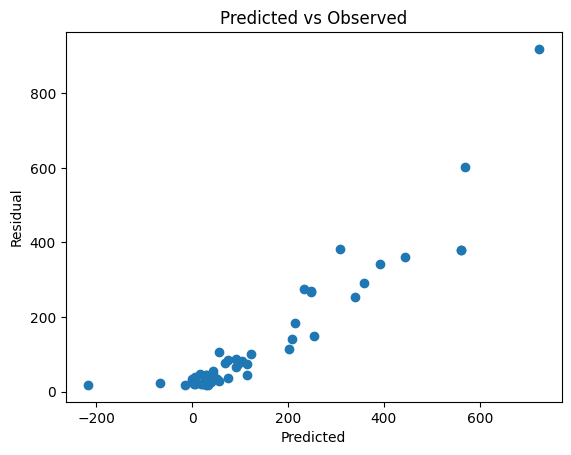

In [21]:
# In order for the model to be interpretable, Y_pred vs y_test must be linear. The model shows a slight curve, indicating that polynomial 
# linear regression will fit better.
plt.scatter(Y_pred, y_test )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Observed")

Text(0.5, 1.0, 'Predicted vs Residual')

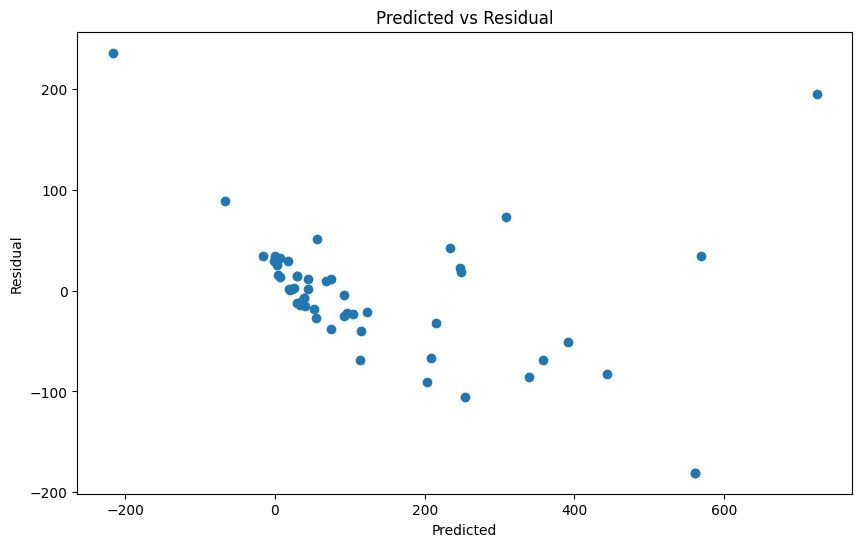

In [22]:
# In order for the model to be useful, the residuals need to be homoskedastic. Here, the residuals have a slight U shaped, indicating
# that a polynomial fit would be better.
plt.scatter(Y_pred, residual )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Residual")

(array([ 3., 17., 29.,  2.,  2.]),
 array([-180.52003972,  -97.2678164 ,  -14.01559308,   69.23663025,
         152.48885357,  235.74107689]),
 <BarContainer object of 5 artists>)

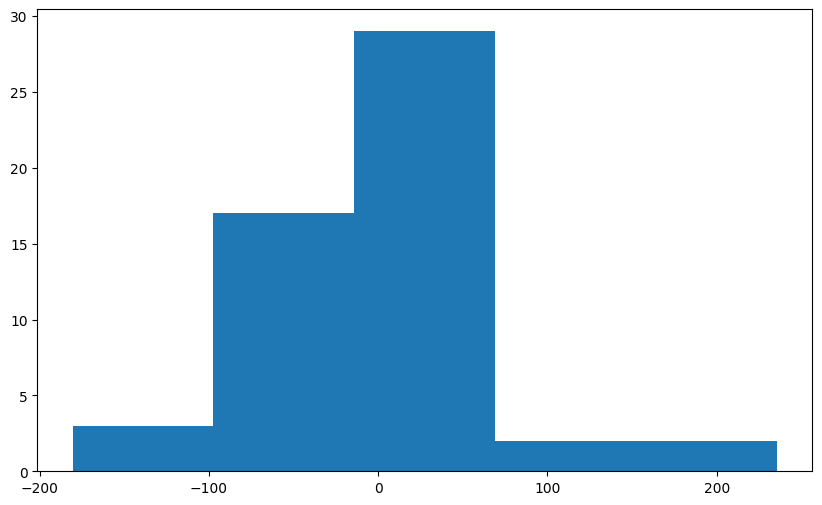

In [23]:
# The residuals are not normally distributed at all.
plt.hist(residual,bins=5)

Part II- Huber Regression:

In [25]:
# The Huber Regression requires normalization for maximum performance.

pipe=Pipeline([('Scale',RobustScaler()),('huber',HuberRegressor(max_iter=3000)) ])


In [26]:
# GridSearchCV by passing the pipeline through:
param = [{'huber__alpha': [0.0001, 0.001, 0.01, 1, 1.5, 2],
              'huber__epsilon': [1,1.1, 1.35, 1.50, 1.75]}]
grid_search= GridSearchCV(pipe, param, cv=5, n_jobs=-1)


In [27]:
grid_search.fit(X_train_final_df, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', RobustScaler()),
                                       ('huber',
                                        HuberRegressor(max_iter=3000))]),
             n_jobs=-1,
             param_grid=[{'huber__alpha': [0.0001, 0.001, 0.01, 1, 1.5, 2],
                          'huber__epsilon': [1, 1.1, 1.35, 1.5, 1.75]}])

In [28]:
print('Best parameter:', grid_search.best_params_ )
print( 'R^2: ',grid_search.best_score_)


Best parameter: {'huber__alpha': 1.5, 'huber__epsilon': 1.35}
R^2:  0.7194545393789544


In [29]:
y_pred = grid_search.predict(X_test_final_df)


In [33]:
scores=cross_val_score(grid_search, X_train_final_df, y_train,scoring='neg_mean_squared_error')
mse=mean_squared_error(y_test, y_pred)
r2=r2_score( y_test,y_pred)
print('Scores: ', scores, '\n', 'MSE:',mse,'    R^2:', r2)


Scores:  [ -4580.60022754 -15566.72025893 -10144.04768644   -293.4270332
  -1156.95722319] 
 MSE: 9656.810116404427     R^2: 0.6670696099843839


Part II- Huber Regression Assumptions:

In [34]:
residual = (y_test - y_pred)

Text(0.5, 1.0, 'Predicted vs Observed')

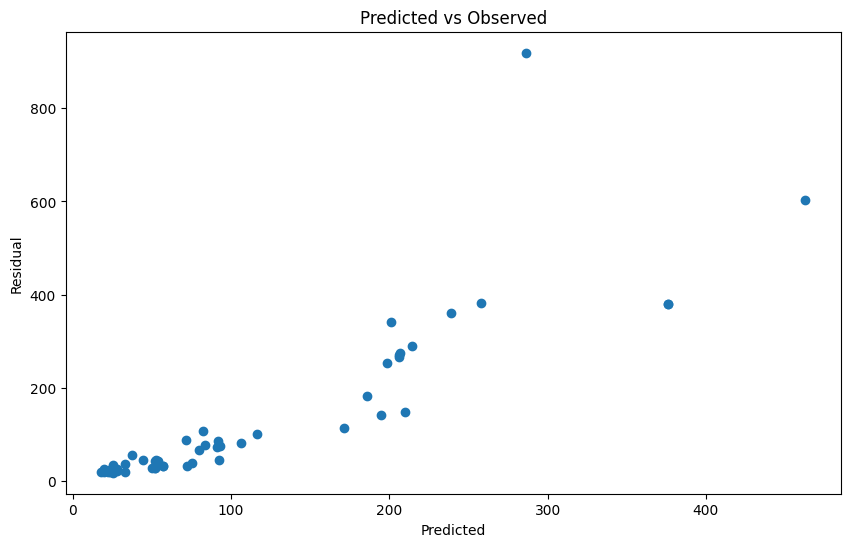

In [35]:
# Again, the graph is almost linear but has a slight curve.
plt.scatter(y_pred, y_test )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Observed")

Text(0.5, 1.0, 'Predicted vs Residual')

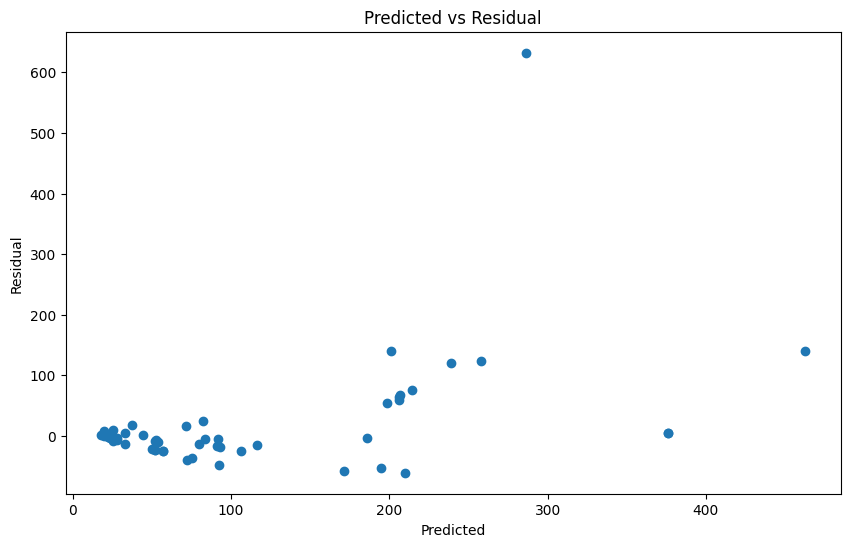

In [36]:
# Homoskedasticity slightly improved
plt.scatter(y_pred, residual )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Residual")

(array([48.,  4.,  0.,  0.,  1.]),
 array([-60.67668754,  77.94235335, 216.56139424, 355.18043513,
        493.79947602, 632.41851691]),
 <BarContainer object of 5 artists>)

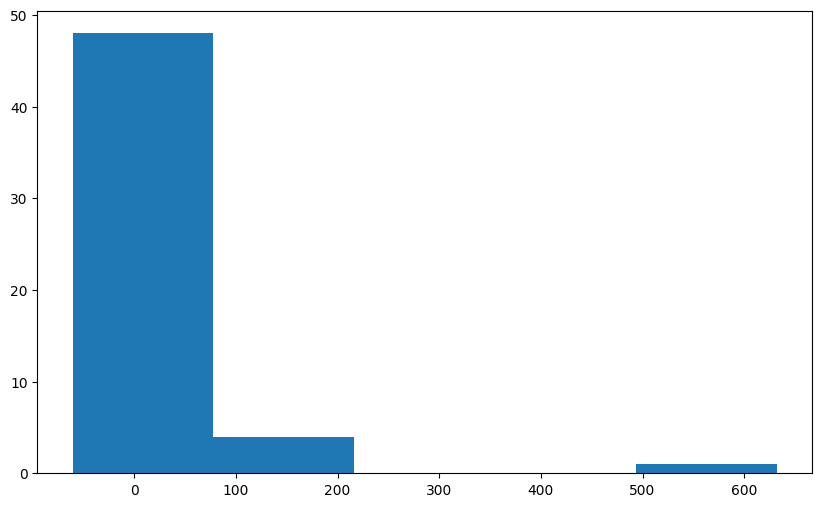

In [37]:
# The residuals aren't normally distriubuted! 
plt.hist(residual,bins=5)

Part III- Polynomial Linear Regression:

Since both the regression and Huber regression do not meet their assumptions, we cannot use them to interprect our model. We will apply the PolynomialFeatures to build our third model.

There are some disadvantages of having a higher degree multilinear regression: May lead to overfitting & is Harder to interpret

In [39]:
# Create a pipe
poly_features = PolynomialFeatures(degree=2)
pipe_=Pipeline([('Scale',RobustScaler()),('pol',PolynomialFeatures(degree=2)),('ridge',linear_model.Ridge() )])


In [40]:
# Grid search by passing the pipe:
param_ = {'ridge__alpha': [.01, .05, .1, 1, 10, 100 ] }
grid_= GridSearchCV(pipe_, param_, cv=5, n_jobs=-1)
grid_.fit(X_train_final, y_train ) #In Lasso, we do not remove multicollinear indep variables and fit all


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', RobustScaler()),
                                       ('pol', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.01, 0.05, 0.1, 1, 10, 100]})

In [41]:
print('Best parameter:',grid_.best_params_ )
print( 'R^2: ',grid_.best_score_)


Best parameter: {'ridge__alpha': 0.01}
R^2:  0.9904302860833576


In [42]:
y_predicted = grid_.predict(X_test_final)


In [43]:
scores=cross_val_score(grid_, X_train_final, y_train, scoring='neg_mean_squared_error')
mse=mean_squared_error(y_test, y_predicted)
r2=r2_score(y_test,y_predicted)
print('Scores: ', scores, '\n', 'MSE:',mse,'    R^2:', r2)


[ -196.16220218  -840.83849909 -3512.71311371   -31.84666244
   -77.5319685 ] 
 MSE: 208.72495581579244     R^2: 0.9928039507758678


In [ ]:
# The R^2 is the greatest and MSE is the smallest compared to Linear and Huber Regressions.

Part III- Polynomial Linear Regression Assumptions

Text(0.5, 1.0, 'Predicted vs Observed')

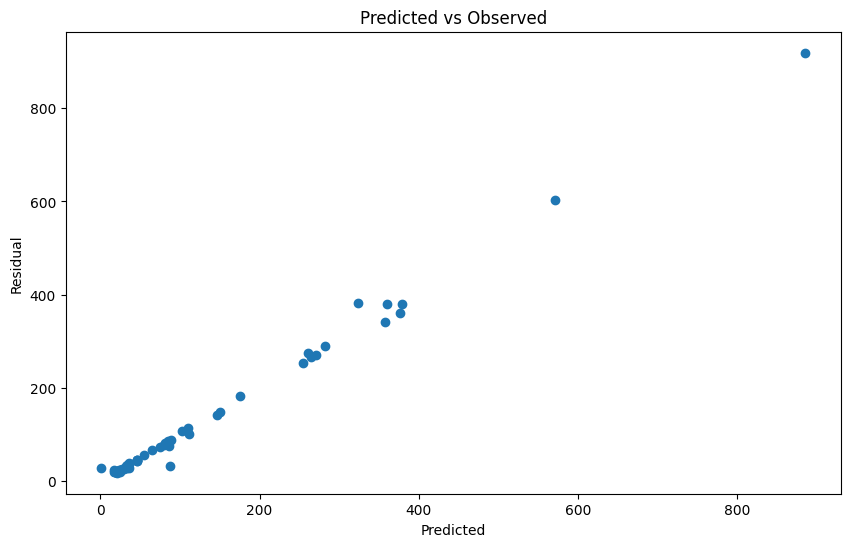

In [45]:
# There is a linearity between observed values and fitted values!
residual_ = (y_test - y_predicted)
plt.scatter(y_predicted, y_test )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Observed")


Text(0.5, 1.0, 'Predicted vs Residual')

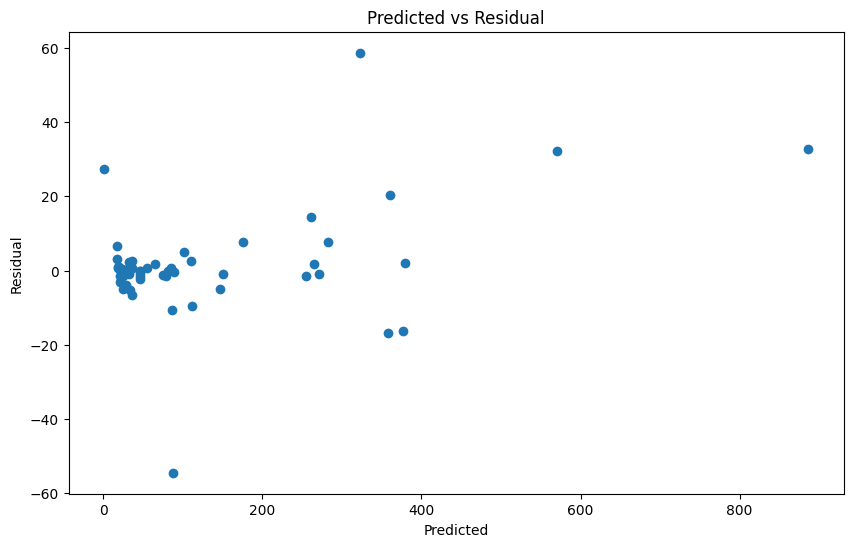

In [46]:
# The residual is not as perfectly homoskedastic and the data points are clustered in the left side, but it has improved from the linear regression mdoel.
plt.scatter(y_predicted, residual_ )
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Predicted vs Residual")

(array([ 1.,  4., 42.,  5.,  1.]),
 array([-54.51290704, -31.86561475,  -9.21832247,  13.42896981,
         36.0762621 ,  58.72355438]),
 <BarContainer object of 5 artists>)

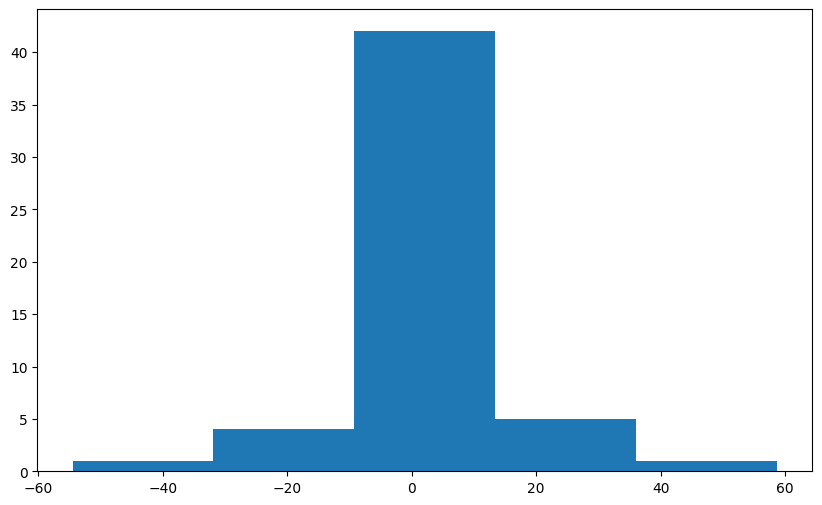

In [47]:
# The residuals are clearly normally distrbuted.
plt.hist(residual_, bins=5)

In [51]:
intercept=grid_.best_estimator_.steps[2][1].intercept_
print('Intercept: ', intercept, '\n')

# Many of these coefficients are almost 0 and we can exclude them from the model
coefficients = grid_.best_estimator_.steps[2][1].coef_
print('Coefficients', coefficients)

Intercept:  43.89513655309512 

Coefficients [ 0.00000000e+00 -2.56748089e+00 -2.03579982e-02 -2.10624007e-01
 -2.53694970e-01  1.30295577e+00  4.01984602e-01 -1.06621775e+00
 -4.92473698e-01  1.99564283e+00 -5.95113624e-01  3.67869903e-01
  0.00000000e+00  8.66750711e-01 -5.01547899e-01  1.00744833e+00
  1.33765028e+00  6.26987301e-01  3.68541811e-01  3.05163311e-01
  0.00000000e+00 -8.39822243e-01  1.02870549e+00 -4.59557805e-01
  4.23991856e-01 -9.37652071e-01 -4.62208608e-01 -1.35928827e+00
 -1.05764771e-01 -1.39507985e-02 -2.82992378e+00  3.96290024e+00
  3.57234959e+01  1.36048795e+01  1.62021244e+00  7.89777012e-01
  2.07868781e+00 -2.56748089e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e

In [49]:
# Referencing coefficients:
feature_names = grid_.best_estimator_.steps[1][1].get_feature_names_out()
print(feature_names)

['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x13' 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20' 'x21' 'x22' 'x23' 'x24'
 'x25' 'x26' 'x27' 'x28' 'x29' 'x30' 'x31' 'x32' 'x33' 'x34' 'x35' 'x0^2'
 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8' 'x0 x9'
 'x0 x10' 'x0 x11' 'x0 x12' 'x0 x13' 'x0 x14' 'x0 x15' 'x0 x16' 'x0 x17'
 'x0 x18' 'x0 x19' 'x0 x20' 'x0 x21' 'x0 x22' 'x0 x23' 'x0 x24' 'x0 x25'
 'x0 x26' 'x0 x27' 'x0 x28' 'x0 x29' 'x0 x30' 'x0 x31' 'x0 x32' 'x0 x33'
 'x0 x34' 'x0 x35' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x1 x6' 'x1 x7'
 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12' 'x1 x13' 'x1 x14' 'x1 x15'
 'x1 x16' 'x1 x17' 'x1 x18' 'x1 x19' 'x1 x20' 'x1 x21' 'x1 x22' 'x1 x23'
 'x1 x24' 'x1 x25' 'x1 x26' 'x1 x27' 'x1 x28' 'x1 x29' 'x1 x30' 'x1 x31'
 'x1 x32' 'x1 x33' 'x1 x34' 'x1 x35' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5'
 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11' 'x2 x12' 'x2 x13'
 'x2 x14' 'x2 x15' 'x2 x16' 'x2 x17' 'x2 x18' 'x2 x19' 'x2 x